In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

## 11.1 日期和时间数据类型及工具
Python标准库包含用于日期（date）和时间（time）数据的数据类型，而且还有日历方面的功能。我们主要会用到datetime、time以及calendar模块。datetime.datetime（也可以简写为datetime）是用得最多的数据类型：


In [2]:
now = datetime.now()
now

datetime.datetime(2019, 8, 25, 10, 56, 9, 206085)

In [3]:
now.year, now.month, now.day

(2019, 8, 25)

datetime以毫秒形式存储日期和时间。timedelta表示两个datetime对象之间的时间差：

In [4]:
delta = datetime(2011, 1, 7) - datetime(2008, 6, 24, 8, 15)
delta

datetime.timedelta(926, 56700)

In [7]:
delta.days,delta.seconds

(926, 56700)

可以给datetime对象加上（或减去）一个或多个timedelta，这样会产生一个新对象：

In [8]:
from datetime import timedelta

In [9]:
start = datetime(2011, 1, 7)
start + timedelta(12)

datetime.datetime(2011, 1, 19, 0, 0)

In [10]:
start - 2 * timedelta(12)

datetime.datetime(2010, 12, 14, 0, 0)

datetime模块中的数据类型参见表10-1。虽然本章主要讲的是pandas数据类型和高级时间序列处理，但你肯定会在Python的其他地方遇到有关datetime的数据类型。
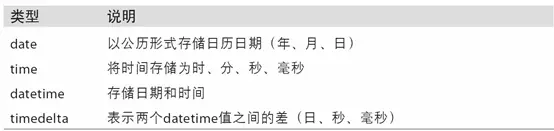
![](https://upload-images.jianshu.io/upload_images/7178691-4af261a305a70aeb.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/554/format/webp)

## 字符串和datetime的相互转换
利用str或strftime方法（传入一个格式化字符串），datetime对象和pandas的Timestamp对象（稍后就会介绍）可以被格式化为字符串：

In [11]:
stamp = datetime(2011, 1, 3)
str(stamp)

'2011-01-03 00:00:00'

In [12]:
stamp.strftime('%Y-%m-%d')

'2011-01-03'

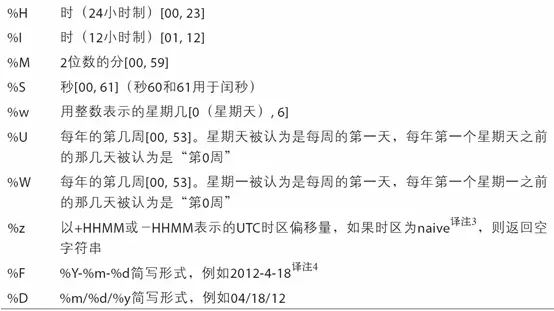

datetime.strptime可以用这些格式化编码将字符串转换为日期：

In [13]:
value = '2011-01-03'
datetime.strptime(value, '%Y-%m-%d')

datetime.datetime(2011, 1, 3, 0, 0)

In [14]:
datestrs = ['7/6/2011', '8/6/2011']
[datetime.strptime(x, '%m/%d/%Y') for x in datestrs]

[datetime.datetime(2011, 7, 6, 0, 0), datetime.datetime(2011, 8, 6, 0, 0)]

datetime.strptime是通过已知格式进行日期解析的最佳方式。但是每次都要编写格式定义是很麻烦的事情，尤其是对于一些常见的日期格式。这种情况下，你可以用dateutil这个第三方包中的parser.parse方法（pandas中已经自动安装好了）：

In [15]:
from dateutil.parser import parse
parse('2011-01-03')

datetime.datetime(2011, 1, 3, 0, 0)

dateutil可以解析几乎所有人类能够理解的日期表示形式：

In [16]:
parse('Jan 31, 1997 10:45 PM')

datetime.datetime(1997, 1, 31, 22, 45)

在国际通用的格式中，日出现在月的前面很普遍，传入dayfirst=True即可解决这个问题：

In [17]:
parse('6/12/2011', dayfirst=True)

datetime.datetime(2011, 12, 6, 0, 0)

pandas通常是用于处理成组日期的，不管这些日期是DataFrame的轴索引还是列。to_datetime方法可以解析多种不同的日期表示形式。对标准日期格式（如ISO8601）的解析非常快

In [18]:
datestrs = ['2011-07-06 12:00:00', '2011-08-06 00:00:00']
pd.to_datetime(datestrs)

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00'], dtype='datetime64[ns]', freq=None)

它还可以处理缺失值（None、空字符串等）：

In [19]:
idx = pd.to_datetime(datestrs + [None])
idx

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00', 'NaT'], dtype='datetime64[ns]', freq=None)

In [20]:
idx[2]

NaT

In [21]:
pd.isnull(idx)

array([False, False,  True])

NaT（Not a Time）是pandas中时间戳数据的null值。

注意：dateutil.parser是一个实用但不完美的工具。比如说，它会把一些原本不是日期的字符串认作是日期（比如"42"会被解析为2042年的今天）。

datetime对象还有一些特定于当前环境（位于不同国家或使用不同语言的系统）的格式化选项。例如，德语或法语系统所用的月份简写就与英语系统所用的不同。表11-3进行了总结。
表11-3 特定于当前环境的日期格式
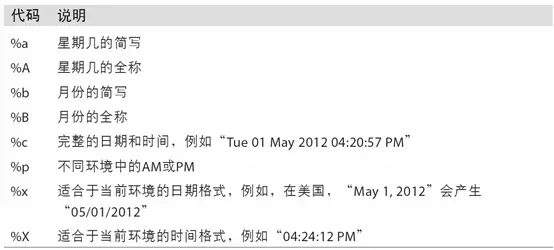

## 11.2 时间序列基础
pandas最基本的时间序列类型就是以时间戳（通常以Python字符串或datatime对象表示）为索引的Series：

In [22]:
dates = [datetime(2011, 1, 2), datetime(2011, 1, 5),datetime(2011, 1, 7), datetime(2011, 1, 8),datetime(2011, 1, 10), datetime(2011, 1, 12)]

In [23]:
ts = pd.Series(np.random.randn(6), index=dates)
ts

2011-01-02   -0.065775
2011-01-05    0.880655
2011-01-07   -0.494145
2011-01-08   -1.083913
2011-01-10   -2.412249
2011-01-12    0.970572
dtype: float64

这些datetime对象实际上是被放在一个DatetimeIndex中的：

In [24]:
ts.index

DatetimeIndex(['2011-01-02', '2011-01-05', '2011-01-07', '2011-01-08',
               '2011-01-10', '2011-01-12'],
              dtype='datetime64[ns]', freq=None)

跟其他Series一样，不同索引的时间序列之间的算术运算会自动按日期对齐：

In [25]:
ts + ts[::2]

2011-01-02   -0.131550
2011-01-05         NaN
2011-01-07   -0.988290
2011-01-08         NaN
2011-01-10   -4.824497
2011-01-12         NaN
dtype: float64

ts[::2] 是每隔两个取一个。

pandas用NumPy的datetime64数据类型以纳秒形式存储时间戳：

In [26]:
ts.index.dtype

dtype('<M8[ns]')

DatetimeIndex中的各个标量值是pandas的Timestamp对象：

In [27]:
stamp = ts.index[0]
stamp

Timestamp('2011-01-02 00:00:00')

只要有需要，TimeStamp可以随时自动转换为datetime对象。此外，它还可以存储频率信息（如果有的话），且知道如何执行时区转换以及其他操作。稍后将对此进行详细讲解。

## 索引、选取、子集构造
当你根据标签索引选取数据时，时间序列和其它的pandas.Series很像：

In [28]:
stamp = ts.index[2]
ts[stamp]

-0.494145035011368

In [29]:
ts['1/10/2011']

-2.4122485059122694

In [30]:
ts['20110110']

-2.4122485059122694

对于较长的时间序列，只需传入“年”或“年月”即可轻松选取数据的切片：

In [31]:
longer_ts = pd.Series(np.random.randn(1000),index=pd.date_range('1/1/2000', periods=1000))

In [32]:
longer_ts

2000-01-01   -1.175410
2000-01-02    0.107498
2000-01-03   -0.056217
2000-01-04    1.049350
2000-01-05   -0.641140
2000-01-06    0.984050
2000-01-07   -0.594788
2000-01-08    0.371557
2000-01-09    1.459686
2000-01-10    0.075997
2000-01-11   -1.009301
2000-01-12   -0.266263
2000-01-13   -0.070638
2000-01-14   -2.342831
2000-01-15    0.643278
2000-01-16    1.470292
2000-01-17    0.173813
2000-01-18    0.282631
2000-01-19   -0.073560
2000-01-20   -0.738780
2000-01-21   -1.044493
2000-01-22   -0.202911
2000-01-23    0.787578
2000-01-24   -0.872214
2000-01-25    2.790477
2000-01-26    1.145281
2000-01-27   -0.959539
2000-01-28    1.161465
2000-01-29   -1.253655
2000-01-30   -0.302661
                ...   
2002-08-28   -0.951809
2002-08-29    0.207069
2002-08-30   -0.408289
2002-08-31    1.684510
2002-09-01    0.038255
2002-09-02    0.396631
2002-09-03   -0.349072
2002-09-04   -1.324140
2002-09-05   -0.576542
2002-09-06    0.480534
2002-09-07    0.569216
2002-09-08   -0.741046
2002-09-09 

In [33]:
longer_ts['2001']

2001-01-01    0.386100
2001-01-02   -1.256483
2001-01-03   -1.151798
2001-01-04   -1.102320
2001-01-05   -1.571154
2001-01-06   -0.235055
2001-01-07   -1.338607
2001-01-08    0.703631
2001-01-09   -0.011723
2001-01-10    1.187960
2001-01-11   -0.085137
2001-01-12    0.469289
2001-01-13   -0.064638
2001-01-14   -0.699458
2001-01-15    0.120577
2001-01-16   -0.161147
2001-01-17   -0.062962
2001-01-18    0.073752
2001-01-19   -1.258811
2001-01-20    0.022549
2001-01-21    0.354535
2001-01-22   -0.640647
2001-01-23    2.095185
2001-01-24    0.336267
2001-01-25    0.361499
2001-01-26   -1.601986
2001-01-27   -0.018712
2001-01-28    0.665339
2001-01-29    0.383885
2001-01-30   -0.180830
                ...   
2001-12-02    1.721967
2001-12-03    0.611200
2001-12-04   -0.491592
2001-12-05   -0.094857
2001-12-06    0.596071
2001-12-07    0.887196
2001-12-08    0.093593
2001-12-09    1.592143
2001-12-10   -0.946413
2001-12-11    2.061003
2001-12-12    0.259737
2001-12-13   -0.324147
2001-12-14 

这里，字符串“2001”被解释成年，并根据它选取时间区间。指定月也同样奏效：

In [34]:
longer_ts['2001-05']

2001-05-01    0.713842
2001-05-02    0.087937
2001-05-03   -1.894818
2001-05-04   -2.479896
2001-05-05    0.082498
2001-05-06    2.563619
2001-05-07    0.423327
2001-05-08   -0.295976
2001-05-09    0.162245
2001-05-10    0.094732
2001-05-11    1.828978
2001-05-12   -0.455708
2001-05-13   -0.263224
2001-05-14   -0.336938
2001-05-15    0.073426
2001-05-16    0.106771
2001-05-17   -1.649495
2001-05-18   -0.067436
2001-05-19   -0.177376
2001-05-20    0.164511
2001-05-21    0.442455
2001-05-22   -1.105382
2001-05-23   -0.115390
2001-05-24   -1.925139
2001-05-25   -0.055017
2001-05-26   -1.120542
2001-05-27   -1.720239
2001-05-28    0.157021
2001-05-29    1.006892
2001-05-30   -0.196111
2001-05-31   -0.508350
Freq: D, dtype: float64

datetime对象也可以进行切片：

In [35]:
ts[datetime(2011, 1, 7):]

2011-01-07   -0.494145
2011-01-08   -1.083913
2011-01-10   -2.412249
2011-01-12    0.970572
dtype: float64

由于大部分时间序列数据都是按照时间先后排序的，因此你也可以用不存在于该时间序列中的时间戳对其进行切片（即范围查询）：

In [36]:
ts

2011-01-02   -0.065775
2011-01-05    0.880655
2011-01-07   -0.494145
2011-01-08   -1.083913
2011-01-10   -2.412249
2011-01-12    0.970572
dtype: float64

In [37]:
ts['1/6/2011':'1/11/2011']

2011-01-07   -0.494145
2011-01-08   -1.083913
2011-01-10   -2.412249
dtype: float64

跟之前一样，你可以传入字符串日期、datetime或Timestamp。注意，这样切片所产生的是原时间序列的视图，跟NumPy数组的切片运算是一样的。
这意味着，没有数据被复制，对切片进行修改会反映到原始数据上。
此外，还有一个等价的实例方法也可以截取两个日期之间TimeSeries：


In [38]:
ts.truncate(after='1/9/2011')

2011-01-02   -0.065775
2011-01-05    0.880655
2011-01-07   -0.494145
2011-01-08   -1.083913
dtype: float64

这些操作对DataFrame也有效。例如，对DataFrame的行进行索引：

In [39]:
dates = pd.date_range('1/1/2000', periods=100, freq='W-WED')

In [40]:
long_df = pd.DataFrame(np.random.randn(100, 4),index=dates,columns=['Colorado', 'Texas','New York', 'Ohio'])
long_df.loc['5-2001']

,Colorado,Texas,New York,Ohio
2001-05-02,-0.954812,0.505178,0.956729,1.797910
2001-05-09,-0.405709,-1.128872,-0.668041,-0.097023
2001-05-16,0.028847,-1.001089,0.636835,-0.664264
2001-05-23,-0.550414,-0.303747,-1.343149,-0.973219
2001-05-30,-1.320463,0.124751,-1.148915,-0.671734


## 带有重复索引的时间序列
在某些应用场景中，可能会存在多个观测数据落在同一个时间点上的情况。下面就是一个例子：

In [41]:
dates = pd.DatetimeIndex(['1/1/2000', '1/2/2000', '1/2/2000', '1/2/2000', '1/3/2000'])
dup_ts = pd.Series(np.arange(5), index=dates)
dup_ts

2000-01-01    0
2000-01-02    1
2000-01-02    2
2000-01-02    3
2000-01-03    4
dtype: int64

通过检查索引的is_unique属性，我们就可以知道它是不是唯一的：

In [42]:
dup_ts.index.is_unique

False

对这个时间序列进行索引，要么产生标量值，要么产生切片，具体要看所选的时间点是否重复：

In [43]:
dup_ts['1/3/2000'] 

4

In [44]:
dup_ts['1/2/2000']

2000-01-02    1
2000-01-02    2
2000-01-02    3
dtype: int64

假设你想要对具有非唯一时间戳的数据进行聚合。一个办法是使用groupby，并传入level=0：

In [45]:
grouped = dup_ts.groupby(level=0)
grouped.mean()

2000-01-01    0
2000-01-02    2
2000-01-03    4
dtype: int64

In [46]:
grouped.count()

2000-01-01    1
2000-01-02    3
2000-01-03    1
dtype: int64

## 11.3 日期的范围、频率以及移动
pandas中的原生时间序列一般被认为是不规则的，也就是说，它们没有固定的频率。对于大部分应用程序而言，这是无所谓的。但是，它常常需要以某种相对固定的频率进行分析，比如每日、每月、每15分钟等（这样自然会在时间序列中引入缺失值）。幸运的是，pandas有一整套标准时间序列频率以及用于重采样、频率推断、生成固定频率日期范围的工具。例如，我们可以将之前那个时间序列转换为一个具有固定频率（每日）的时间序列，只需调用resample即可：


In [47]:
ts

2011-01-02   -0.065775
2011-01-05    0.880655
2011-01-07   -0.494145
2011-01-08   -1.083913
2011-01-10   -2.412249
2011-01-12    0.970572
dtype: float64

字符串“D”是每天的意思。

频率的转换（或重采样）是一个比较大的主题，稍后将专门用一节来进行讨论（11.6小节）。这里，我将告诉你如何使用基本的频率和它的倍数。
## 生成日期范围
虽然我之前用的时候没有明说，但你可能已经猜到pandas.date_range可用于根据指定的频率生成指定长度的DatetimeIndex：


In [48]:
index = pd.date_range('2012-04-01', '2012-06-01')
index

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20',
               '2012-04-21', '2012-04-22', '2012-04-23', '2012-04-24',
               '2012-04-25', '2012-04-26', '2012-04-27', '2012-04-28',
               '2012-04-29', '2012-04-30', '2012-05-01', '2012-05-02',
               '2012-05-03', '2012-05-04', '2012-05-05', '2012-05-06',
               '2012-05-07', '2012-05-08', '2012-05-09', '2012-05-10',
               '2012-05-11', '2012-05-12', '2012-05-13', '2012-05-14',
               '2012-05-15', '2012-05-16', '2012-05-17', '2012-05-18',
               '2012-05-19', '2012-05-20', '2012-05-21', '2012-05-22',
               '2012-05-23', '2012-05-24', '2012-05-25', '2012-05-26',
      

默认情况下，date_range会产生按天计算的时间点。如果只传入起始或结束日期，那就还得传入一个表示一段时间的数字：

In [49]:
pd.date_range(start='2012-04-01', periods=20)

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20'],
              dtype='datetime64[ns]', freq='D')

In [50]:
pd.date_range(end='2012-06-01', periods=20)

DatetimeIndex(['2012-05-13', '2012-05-14', '2012-05-15', '2012-05-16',
               '2012-05-17', '2012-05-18', '2012-05-19', '2012-05-20',
               '2012-05-21', '2012-05-22', '2012-05-23', '2012-05-24',
               '2012-05-25', '2012-05-26', '2012-05-27', '2012-05-28',
               '2012-05-29', '2012-05-30', '2012-05-31', '2012-06-01'],
              dtype='datetime64[ns]', freq='D')

起始和结束日期定义了日期索引的严格边界。例如，如果你想要生成一个由每月最后一个工作日组成的日期索引，可以传入"BM"频率（表示business end of month，表11-4是频率列表），这样就只会包含时间间隔内（或刚好在边界上的）符合频率要求的日期：

In [51]:
pd.date_range('2000-01-01', '2000-12-01', freq='BM')

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-28',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-29', '2000-10-31', '2000-11-30'],
              dtype='datetime64[ns]', freq='BM')

![image.png](https://upload-images.jianshu.io/upload_images/7178691-c8614ddbd10793ca.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/554/format/webp)
![](https://upload-images.jianshu.io/upload_images/7178691-8da46ba96544b071.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/554/format/webp)
![](https://upload-images.jianshu.io/upload_images/7178691-3ca410609195edc4.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/554/format/webp)

date_range默认会保留起始和结束时间戳的时间信息（如果有的话）：

In [52]:
pd.date_range('2012-05-02 12:56:31', periods=5)

DatetimeIndex(['2012-05-02 12:56:31', '2012-05-03 12:56:31',
               '2012-05-04 12:56:31', '2012-05-05 12:56:31',
               '2012-05-06 12:56:31'],
              dtype='datetime64[ns]', freq='D')

有时，虽然起始和结束日期带有时间信息，但你希望产生一组被规范化（normalize）到午夜的时间戳。normalize选项即可实现该功能：

In [53]:
pd.date_range('2012-05-02 12:56:31', periods=5, normalize=True)

DatetimeIndex(['2012-05-02', '2012-05-03', '2012-05-04', '2012-05-05',
               '2012-05-06'],
              dtype='datetime64[ns]', freq='D')

## 频率和日期偏移量
pandas中的频率是由一个基础频率（base frequency）和一个乘数组成的。基础频率通常以一个字符串别名表示，比如"M"表示每月，"H"表示每小时。对于每个基础频率，都有一个被称为日期偏移量（date offset）的对象与之对应。例如，按小时计算的频率可以用Hour类表示：


In [54]:
from pandas.tseries.offsets import Hour, Minute
hour = Hour()
hour

<Hour>

传入一个整数即可定义偏移量的倍数：

In [55]:
four_hours = Hour(4)
four_hours

<4 * Hours>

一般来说，无需明确创建这样的对象，只需使用诸如"H"或"4H"这样的字符串别名即可。在基础频率前面放上一个整数即可创建倍数：

In [56]:
pd.date_range('2000-01-01', '2000-01-03 23:59', freq='4h')

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 04:00:00',
               '2000-01-01 08:00:00', '2000-01-01 12:00:00',
               '2000-01-01 16:00:00', '2000-01-01 20:00:00',
               '2000-01-02 00:00:00', '2000-01-02 04:00:00',
               '2000-01-02 08:00:00', '2000-01-02 12:00:00',
               '2000-01-02 16:00:00', '2000-01-02 20:00:00',
               '2000-01-03 00:00:00', '2000-01-03 04:00:00',
               '2000-01-03 08:00:00', '2000-01-03 12:00:00',
               '2000-01-03 16:00:00', '2000-01-03 20:00:00'],
              dtype='datetime64[ns]', freq='4H')

大部分偏移量对象都可通过加法进行连接：

In [57]:
Hour(2) + Minute(30)

<150 * Minutes>

同理，你也可以传入频率字符串（如"2h30min"），这种字符串可以被高效地解析为等效的表达式：

In [58]:
pd.date_range('2000-01-01', periods=10, freq='1h30min')

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 01:30:00',
               '2000-01-01 03:00:00', '2000-01-01 04:30:00',
               '2000-01-01 06:00:00', '2000-01-01 07:30:00',
               '2000-01-01 09:00:00', '2000-01-01 10:30:00',
               '2000-01-01 12:00:00', '2000-01-01 13:30:00'],
              dtype='datetime64[ns]', freq='90T')

有些频率所描述的时间点并不是均匀分隔的。例如，"M"（日历月末）和"BM"（每月最后一个工作日）就取决于每月的天数，对于后者，还要考虑月末是不是周末。由于没有更好的术语，我将这些称为锚点偏移量（anchored offset）。

![](https://upload-images.jianshu.io/upload_images/7178691-ff139312cd972204.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/554/format/webp)
![](https://upload-images.jianshu.io/upload_images/7178691-adfa57a998c0296e.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/554/format/webp)
![](https://upload-images.jianshu.io/upload_images/7178691-d09e577a10d0e6eb.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/554/format/webp)

## WOM日期
WOM（Week Of Month）是一种非常实用的频率类，它以WOM开头。它使你能获得诸如“每月第3个星期五”之类的日期：

In [59]:
rng = pd.date_range('2012-01-01', '2012-09-01', freq='WOM-3FRI')
list(rng)

[Timestamp('2012-01-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-02-17 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-03-16 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-04-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-05-18 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-06-15 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-07-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-08-17 00:00:00', freq='WOM-3FRI')]

## 移动（超前和滞后）数据
移动（shifting）指的是沿着时间轴将数据前移或后移。Series和DataFrame都有一个shift方法用于执行单纯的前移或后移操作，保持索引不变：

In [60]:
ts = pd.Series(np.random.randn(4),index=pd.date_range('1/1/2000', periods=4, freq='M'))
ts

2000-01-31   -2.168316
2000-02-29    2.278426
2000-03-31    0.916601
2000-04-30   -0.127666
Freq: M, dtype: float64

In [61]:
ts.shift(2)

2000-01-31         NaN
2000-02-29         NaN
2000-03-31   -2.168316
2000-04-30    2.278426
Freq: M, dtype: float64

In [62]:
ts.shift(-2)

2000-01-31    0.916601
2000-02-29   -0.127666
2000-03-31         NaN
2000-04-30         NaN
Freq: M, dtype: float64

当我们这样进行移动时，就会在时间序列的前面或后面产生缺失数据。

shift通常用于计算一个时间序列或多个时间序列（如DataFrame的列）中的百分比变化。可以这样表达：

In [63]:
ts / ts.shift(1) - 1

2000-01-31         NaN
2000-02-29   -2.050781
2000-03-31   -0.597704
2000-04-30   -1.139283
Freq: M, dtype: float64

由于单纯的移位操作不会修改索引，所以部分数据会被丢弃。因此，如果频率已知，则可以将其传给shift以便实现对时间戳进行位移而不是对数据进行简单位移：

In [64]:
ts.shift(2, freq='M')

2000-03-31   -2.168316
2000-04-30    2.278426
2000-05-31    0.916601
2000-06-30   -0.127666
Freq: M, dtype: float64

这里还可以使用其他频率，于是你就能非常灵活地对数据进行超前和滞后处理了：

In [65]:
ts.shift(3, freq='D')

2000-02-03   -2.168316
2000-03-03    2.278426
2000-04-03    0.916601
2000-05-03   -0.127666
dtype: float64

## 通过偏移量对日期进行位移
pandas的日期偏移量还可以用在datetime或Timestamp对象上：

In [66]:
from pandas.tseries.offsets import Day, MonthEnd
now = datetime(2011, 11, 17)

In [67]:
now + 3 * Day()

Timestamp('2011-11-20 00:00:00')

如果加的是锚点偏移量（比如MonthEnd），第一次增量会将原日期向前滚动到符合频率规则的下一个日期：

In [68]:
now + MonthEnd()

Timestamp('2011-11-30 00:00:00')

In [69]:
now + MonthEnd(2)

Timestamp('2011-12-31 00:00:00')

通过锚点偏移量的rollforward和rollback方法，可明确地将日期向前或向后“滚动”：

In [70]:
offset = MonthEnd()
offset.rollforward(now)

Timestamp('2011-11-30 00:00:00')

In [71]:
offset.rollback(now)

Timestamp('2011-10-31 00:00:00')

日期偏移量还有一个巧妙的用法，即结合groupby使用这两个“滚动”方法：

In [72]:
ts = pd.Series(np.random.randn(20),index=pd.date_range('1/15/2000', periods=20, freq='4d'))
ts

2000-01-15   -1.969161
2000-01-19   -0.977954
2000-01-23    2.208522
2000-01-27   -0.083013
2000-01-31   -0.199122
2000-02-04    1.335505
2000-02-08   -0.024593
2000-02-12   -0.277222
2000-02-16    1.030661
2000-02-20   -1.270540
2000-02-24   -1.162085
2000-02-28    0.236648
2000-03-03    2.844729
2000-03-07   -0.838091
2000-03-11    0.331623
2000-03-15    1.602382
2000-03-19   -0.659037
2000-03-23   -0.319555
2000-03-27   -0.504607
2000-03-31   -0.091587
Freq: 4D, dtype: float64

In [73]:
ts.groupby(offset.rollforward).mean()

2000-01-31   -0.204146
2000-02-29   -0.018804
2000-03-31    0.295732
dtype: float64

In [74]:
ts.resample('M').mean()

2000-01-31   -0.204146
2000-02-29   -0.018804
2000-03-31    0.295732
Freq: M, dtype: float64

## 11.4 时区处理
时间序列处理工作中最让人不爽的就是对时区的处理。许多人都选择以协调世界时（UTC，它是格林尼治标准时间（Greenwich Mean Time）的接替者，目前已经是国际标准了）来处理时间序列。时区是以UTC偏移量的形式表示的。例如，夏令时期间，纽约比UTC慢4小时，而在全年其他时间则比UTC慢5小时。

在Python中，时区信息来自第三方库pytz，它使Python可以使用Olson数据库（汇编了世界时区信息）。这对历史数据非常重要，这是因为由于各地政府的各种突发奇想，夏令时转变日期（甚至UTC偏移量）已经发生过多次改变了。就拿美国来说，DST转变时间自1900年以来就改变过多次！

有关pytz库的更多信息，请查阅其文档。就本书而言，由于pandas包装了pytz的功能，因此你可以不用记忆其API，只要记得时区的名称即可。时区名可以在shell中看到，也可以通过文档查看：


In [75]:
import pytz

In [76]:
pytz.common_timezones[-5:]

['US/Eastern', 'US/Hawaii', 'US/Mountain', 'US/Pacific', 'UTC']

要从pytz中获取时区对象，使用pytz.timezone即可：

In [77]:
tz = pytz.timezone('America/New_York')
tz

<DstTzInfo 'America/New_York' LMT-1 day, 19:04:00 STD>

## 时区本地化和转换
默认情况下，pandas中的时间序列是单纯（naive）的时区。看看下面这个时间序列：

In [78]:
rng = pd.date_range('3/9/2012 9:30', periods=6, freq='D')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2012-03-09 09:30:00   -0.218789
2012-03-10 09:30:00   -0.262105
2012-03-11 09:30:00    0.856608
2012-03-12 09:30:00    0.681644
2012-03-13 09:30:00   -0.528107
2012-03-14 09:30:00    0.555219
Freq: D, dtype: float64

其索引的tz字段为None：

In [79]:
print(ts.index.tz)

None


可以用时区集生成日期范围：

In [80]:
pd.date_range('3/9/2012 9:30', periods=10, freq='D', tz='UTC')

DatetimeIndex(['2012-03-09 09:30:00+00:00', '2012-03-10 09:30:00+00:00',
               '2012-03-11 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00',
               '2012-03-15 09:30:00+00:00', '2012-03-16 09:30:00+00:00',
               '2012-03-17 09:30:00+00:00', '2012-03-18 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

从单纯到本地化的转换是通过tz_localize方法处理的：

In [81]:
ts

2012-03-09 09:30:00   -0.218789
2012-03-10 09:30:00   -0.262105
2012-03-11 09:30:00    0.856608
2012-03-12 09:30:00    0.681644
2012-03-13 09:30:00   -0.528107
2012-03-14 09:30:00    0.555219
Freq: D, dtype: float64

In [82]:
ts_utc = ts.tz_localize('UTC')

In [83]:
ts_utc

2012-03-09 09:30:00+00:00   -0.218789
2012-03-10 09:30:00+00:00   -0.262105
2012-03-11 09:30:00+00:00    0.856608
2012-03-12 09:30:00+00:00    0.681644
2012-03-13 09:30:00+00:00   -0.528107
2012-03-14 09:30:00+00:00    0.555219
Freq: D, dtype: float64

In [84]:
ts_utc.index

DatetimeIndex(['2012-03-09 09:30:00+00:00', '2012-03-10 09:30:00+00:00',
               '2012-03-11 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

一旦时间序列被本地化到某个特定时区，就可以用tz_convert将其转换到别的时区了：

In [85]:
ts_utc.tz_convert('America/New_York')

2012-03-09 04:30:00-05:00   -0.218789
2012-03-10 04:30:00-05:00   -0.262105
2012-03-11 05:30:00-04:00    0.856608
2012-03-12 05:30:00-04:00    0.681644
2012-03-13 05:30:00-04:00   -0.528107
2012-03-14 05:30:00-04:00    0.555219
Freq: D, dtype: float64

对于上面这种时间序列（它跨越了美国东部时区的夏令时转变期），我们可以将其本地化到EST，然后转换为UTC或柏林时间：

In [86]:
ts_eastern = ts.tz_localize('America/New_York')

In [87]:
ts_eastern.tz_convert('UTC')

2012-03-09 14:30:00+00:00   -0.218789
2012-03-10 14:30:00+00:00   -0.262105
2012-03-11 13:30:00+00:00    0.856608
2012-03-12 13:30:00+00:00    0.681644
2012-03-13 13:30:00+00:00   -0.528107
2012-03-14 13:30:00+00:00    0.555219
Freq: D, dtype: float64

In [88]:
ts_eastern.tz_convert('Europe/Berlin')

2012-03-09 15:30:00+01:00   -0.218789
2012-03-10 15:30:00+01:00   -0.262105
2012-03-11 14:30:00+01:00    0.856608
2012-03-12 14:30:00+01:00    0.681644
2012-03-13 14:30:00+01:00   -0.528107
2012-03-14 14:30:00+01:00    0.555219
Freq: D, dtype: float64

tz_localize和tz_convert也是DatetimeIndex的实例方法：

In [89]:
ts.index.tz_localize('Asia/Shanghai')

DatetimeIndex(['2012-03-09 09:30:00+08:00', '2012-03-10 09:30:00+08:00',
               '2012-03-11 09:30:00+08:00', '2012-03-12 09:30:00+08:00',
               '2012-03-13 09:30:00+08:00', '2012-03-14 09:30:00+08:00'],
              dtype='datetime64[ns, Asia/Shanghai]', freq='D')

## 操作时区意识型Timestamp对象
跟时间序列和日期范围差不多，独立的Timestamp对象也能被从单纯型（naive）本地化为时区意识型（time zone-aware），并从一个时区转换到另一个时区：

In [90]:
stamp = pd.Timestamp('2011-03-12 04:00')
stamp_utc = stamp.tz_localize('utc')

In [91]:
stamp_utc.tz_convert('America/New_York')

Timestamp('2011-03-11 23:00:00-0500', tz='America/New_York')

In [92]:
stamp_moscow = pd.Timestamp('2011-03-12 04:00', tz='Europe/Moscow')
stamp_moscow

Timestamp('2011-03-12 04:00:00+0300', tz='Europe/Moscow')

时区意识型Timestamp对象在内部保存了一个UTC时间戳值（自UNIX纪元（1970年1月1日）算起的纳秒数）。这个UTC值在时区转换过程中是不会发生变化的：

In [93]:
stamp_utc.value

1299902400000000000

In [94]:
stamp_utc.tz_convert('America/New_York').value

1299902400000000000

当使用pandas的DateOffset对象执行时间算术运算时，运算过程会自动关注是否存在夏令时转变期。这里，我们创建了在DST转变之前的时间戳。首先，来看夏令时转变前的30分钟：

In [95]:
from pandas.tseries.offsets import Hour

In [96]:
stamp = pd.Timestamp('2012-03-12 01:30', tz='US/Eastern')
stamp

Timestamp('2012-03-12 01:30:00-0400', tz='US/Eastern')

In [97]:
stamp + Hour()

Timestamp('2012-03-12 02:30:00-0400', tz='US/Eastern')

In [98]:
stamp = pd.Timestamp('2012-11-04 00:30', tz='US/Eastern')
stamp

Timestamp('2012-11-04 00:30:00-0400', tz='US/Eastern')

In [99]:
stamp + 2 * Hour()

Timestamp('2012-11-04 01:30:00-0500', tz='US/Eastern')

## 不同时区之间的运算
如果两个时间序列的时区不同，在将它们合并到一起时，最终结果就会是UTC。由于时间戳其实是以UTC存储的，所以这是一个很简单的运算，并不需要发生任何转换：

In [100]:
rng = pd.date_range('3/7/2012 9:30', periods=10, freq='B')
ts = pd.Series(np.random.randn(len(rng)), index=rng)

In [101]:
ts

2012-03-07 09:30:00   -0.267907
2012-03-08 09:30:00    0.597052
2012-03-09 09:30:00   -0.828884
2012-03-12 09:30:00    0.511672
2012-03-13 09:30:00   -0.129179
2012-03-14 09:30:00   -2.688749
2012-03-15 09:30:00    0.123445
2012-03-16 09:30:00    0.294407
2012-03-19 09:30:00    1.663521
2012-03-20 09:30:00   -0.366701
Freq: B, dtype: float64

In [102]:
ts1 = ts[:7].tz_localize('Europe/London')
ts2 = ts1[2:].tz_convert('Europe/Moscow')
result = ts1 + ts2


In [103]:
result.index

DatetimeIndex(['2012-03-07 09:30:00+00:00', '2012-03-08 09:30:00+00:00',
               '2012-03-09 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00',
               '2012-03-15 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='B')

## 11.5 时期及其算术运算
时期（period）表示的是时间区间，比如数日、数月、数季、数年等。Period类所表示的就是这种数据类型，其构造函数需要用到一个字符串或整数，以及表11-4中的频率：

In [104]:
p = pd.Period(2007, freq='A-DEC')
p

Period('2007', 'A-DEC')

这里，这个Period对象表示的是从2007年1月1日到2007年12月31日之间的整段时间。只需对Period对象加上或减去一个整数即可达到根据其频率进行位移的效果：

In [105]:
p + 5

Period('2012', 'A-DEC')

In [106]:
p - 2

Period('2005', 'A-DEC')

如果两个Period对象拥有相同的频率，则它们的差就是它们之间的单位数量：

In [107]:
pd.Period('2014', freq='A-DEC') - p

7

period_range函数可用于创建规则的时期范围：

In [108]:
rng = pd.period_range('2000-01-01', '2000-06-30', freq='M')
rng

PeriodIndex(['2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06'], dtype='period[M]', freq='M')

PeriodIndex类保存了一组Period，它可以在任何pandas数据结构中被用作轴索引

In [109]:
pd.Series(np.random.randn(6), index=rng)


2000-01   -0.295843
2000-02   -1.094867
2000-03    0.958275
2000-04    0.889309
2000-05    1.167376
2000-06   -0.465148
Freq: M, dtype: float64

如果你有一个字符串数组，你也可以使用PeriodIndex类：

In [110]:
values = ['2001Q3', '2002Q2', '2003Q1']
index = pd.PeriodIndex(values, freq='Q-DEC')
index

PeriodIndex(['2001Q3', '2002Q2', '2003Q1'], dtype='period[Q-DEC]', freq='Q-DEC')

## 时期的频率转换
Period和PeriodIndex对象都可以通过其asfreq方法被转换成别的频率。假设我们有一个年度时期，希望将其转换为当年年初或年末的一个月度时期。该任务非常简单：

In [111]:
p = pd.Period('2007', freq='A-DEC')
p

Period('2007', 'A-DEC')

In [112]:
p.asfreq('M', how='start')

Period('2007-01', 'M')

In [113]:
p.asfreq('M', how='end')

Period('2007-12', 'M')

你可以将Period('2007','A-DEC')看做一个被划分为多个月度时期的时间段中的游标。图11-1对此进行了说明。对于一个不以12月结束的财政年度，月度子时期的归属情况就不一样了：

In [114]:
p = pd.Period('2007', freq='A-JUN')
p

Period('2007', 'A-JUN')

在将高频率转换为低频率时，超时期（superperiod）是由子时期（subperiod）所属的位置决定的。例如，在A-JUN频率中，月份“2007年8月”实际上是属于周期“2008年”的：

In [115]:
p = pd.Period('Aug-2007', 'M')
p.asfreq('A-JUN')

Period('2008', 'A-JUN')

## 将Timestamp转换为Period（及其反向过程）
通过使用to_period方法，可以将由时间戳索引的Series和DataFrame对象转换为以时期索引：

In [116]:
rng = pd.date_range('2000-01-01', periods=3, freq='M')
ts = pd.Series(np.random.randn(3), index=rng)
ts

2000-01-31    0.477286
2000-02-29   -2.196680
2000-03-31    0.629786
Freq: M, dtype: float64

由于时期指的是非重叠时间区间，因此对于给定的频率，一个时间戳只能属于一个时期。新PeriodIndex的频率默认是从时间戳推断而来的，你也可以指定任何别的频率。结果中允许存在重复时期：

In [117]:
rng = pd.date_range('1/29/2000', periods=6, freq='D')
ts2 = pd.Series(np.random.randn(6), index=rng)
ts2

2000-01-29    0.719144
2000-01-30    0.045010
2000-01-31    1.598252
2000-02-01    0.119688
2000-02-02   -1.430084
2000-02-03    0.088552
Freq: D, dtype: float64

In [118]:
ts2.to_period('M')

2000-01    0.719144
2000-01    0.045010
2000-01    1.598252
2000-02    0.119688
2000-02   -1.430084
2000-02    0.088552
Freq: M, dtype: float64

## 11.6 重采样及频率转换
重采样（resampling）指的是将时间序列从一个频率转换到另一个频率的处理过程。将高频率数据聚合到低频率称为降采样（downsampling），而将低频率数据转换到高频率则称为升采样（upsampling）。并不是所有的重采样都能被划分到这两个大类中。例如，将W-WED（每周三）转换为W-FRI既不是降采样也不是升采样。
pandas对象都带有一个resample方法，它是各种频率转换工作的主力函数。resample有一个类似于groupby的API，调用resample可以分组数据，然后会调用一个聚合函数：


In [119]:
ts.resample('M').mean()

2000-01-31    0.477286
2000-02-29   -2.196680
2000-03-31    0.629786
Freq: M, dtype: float64

In [120]:
ts.resample('M', kind='period').mean()

2000-01    0.477286
2000-02   -2.196680
2000-03    0.629786
Freq: M, dtype: float64

resample是一个灵活高效的方法，可用于处理非常大的时间序列。我将通过一系列的示例说明其用法。表11-5总结它的一些选项。
![](https://upload-images.jianshu.io/upload_images/7178691-b40a57086c904e83.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/757/format/webp)

## 降采样
将数据聚合到规律的低频率是一件非常普通的时间序列处理任务。待聚合的数据不必拥有固定的频率，期望的频率会自动定义聚合的面元边界，这些面元用于将时间序列拆分为多个片段。例如，要转换到月度频率（'M'或'BM'），数据需要被划分到多个单月时间段中。各时间段都是半开放的。一个数据点只能属于一个时间段，所有时间段的并集必须能组成整个时间帧。在用resample对数据进行降采样时，需要考虑两样东西：

各区间哪边是闭合的。
如何标记各个聚合面元，用区间的开头还是末尾。

为了说明，我们来看一些“1分钟”数据：


In [122]:
ts.resample('5min', closed='right').sum()

2000-01-30 23:55:00    0.477286
2000-01-31 00:00:00    0.000000
2000-01-31 00:05:00    0.000000
2000-01-31 00:10:00    0.000000
2000-01-31 00:15:00    0.000000
2000-01-31 00:20:00    0.000000
2000-01-31 00:25:00    0.000000
2000-01-31 00:30:00    0.000000
2000-01-31 00:35:00    0.000000
2000-01-31 00:40:00    0.000000
2000-01-31 00:45:00    0.000000
2000-01-31 00:50:00    0.000000
2000-01-31 00:55:00    0.000000
2000-01-31 01:00:00    0.000000
2000-01-31 01:05:00    0.000000
2000-01-31 01:10:00    0.000000
2000-01-31 01:15:00    0.000000
2000-01-31 01:20:00    0.000000
2000-01-31 01:25:00    0.000000
2000-01-31 01:30:00    0.000000
2000-01-31 01:35:00    0.000000
2000-01-31 01:40:00    0.000000
2000-01-31 01:45:00    0.000000
2000-01-31 01:50:00    0.000000
2000-01-31 01:55:00    0.000000
2000-01-31 02:00:00    0.000000
2000-01-31 02:05:00    0.000000
2000-01-31 02:10:00    0.000000
2000-01-31 02:15:00    0.000000
2000-01-31 02:20:00    0.000000
                         ...   
2000-03-

传入的频率将会以“5分钟”的增量定义面元边界。默认情况下，面元的右边界是包含的，因此00:00到00:05的区间中是包含00:05的。传入closed='left'会让区间以左边界闭合：

In [123]:
ts.resample('5min', closed='right').sum()

2000-01-30 23:55:00    0.477286
2000-01-31 00:00:00    0.000000
2000-01-31 00:05:00    0.000000
2000-01-31 00:10:00    0.000000
2000-01-31 00:15:00    0.000000
2000-01-31 00:20:00    0.000000
2000-01-31 00:25:00    0.000000
2000-01-31 00:30:00    0.000000
2000-01-31 00:35:00    0.000000
2000-01-31 00:40:00    0.000000
2000-01-31 00:45:00    0.000000
2000-01-31 00:50:00    0.000000
2000-01-31 00:55:00    0.000000
2000-01-31 01:00:00    0.000000
2000-01-31 01:05:00    0.000000
2000-01-31 01:10:00    0.000000
2000-01-31 01:15:00    0.000000
2000-01-31 01:20:00    0.000000
2000-01-31 01:25:00    0.000000
2000-01-31 01:30:00    0.000000
2000-01-31 01:35:00    0.000000
2000-01-31 01:40:00    0.000000
2000-01-31 01:45:00    0.000000
2000-01-31 01:50:00    0.000000
2000-01-31 01:55:00    0.000000
2000-01-31 02:00:00    0.000000
2000-01-31 02:05:00    0.000000
2000-01-31 02:10:00    0.000000
2000-01-31 02:15:00    0.000000
2000-01-31 02:20:00    0.000000
                         ...   
2000-03-

如你所见，最终的时间序列是以各面元右边界的时间戳进行标记的。传入label='right'即可用面元的邮编界对其进行标记：

In [125]:
ts.resample('5min', closed='right', label='right').sum()

2000-01-31 00:00:00    0.477286
2000-01-31 00:05:00    0.000000
2000-01-31 00:10:00    0.000000
2000-01-31 00:15:00    0.000000
2000-01-31 00:20:00    0.000000
2000-01-31 00:25:00    0.000000
2000-01-31 00:30:00    0.000000
2000-01-31 00:35:00    0.000000
2000-01-31 00:40:00    0.000000
2000-01-31 00:45:00    0.000000
2000-01-31 00:50:00    0.000000
2000-01-31 00:55:00    0.000000
2000-01-31 01:00:00    0.000000
2000-01-31 01:05:00    0.000000
2000-01-31 01:10:00    0.000000
2000-01-31 01:15:00    0.000000
2000-01-31 01:20:00    0.000000
2000-01-31 01:25:00    0.000000
2000-01-31 01:30:00    0.000000
2000-01-31 01:35:00    0.000000
2000-01-31 01:40:00    0.000000
2000-01-31 01:45:00    0.000000
2000-01-31 01:50:00    0.000000
2000-01-31 01:55:00    0.000000
2000-01-31 02:00:00    0.000000
2000-01-31 02:05:00    0.000000
2000-01-31 02:10:00    0.000000
2000-01-31 02:15:00    0.000000
2000-01-31 02:20:00    0.000000
2000-01-31 02:25:00    0.000000
                         ...   
2000-03-

## 1.7 移动窗口函数
在移动窗口（可以带有指数衰减权数）上计算的各种统计函数也是一类常见于时间序列的数组变换。这样可以圆滑噪音数据或断裂数据。我将它们称为移动窗口函数（moving window function），其中还包括那些窗口不定长的函数（如指数加权移动平均）。跟其他统计函数一样，移动窗口函数也会自动排除缺失值。
开始之前，我们加载一些时间序列数据，将其重采样为工作日频率：


In [126]:
lose_px_all = pd.read_csv('examples/stock_px_2.csv',parse_dates=True, index_col=0)
close_px = close_px_all[['AAPL', 'MSFT', 'XOM']]
close_px = close_px.resample('B').ffill()

FileNotFoundError: File b'examples/stock_px_2.csv' does not exist